<a href="https://colab.research.google.com/github/demilade27/Predicting-Monthly-Excess-Returns-of-Market-Index/blob/main/Predicting_Monthly_Excess_Returns_of_Market_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-requisite




## Import Libraries


In [647]:
# Comment out the pip requirement 
# !pip install -r requirements.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Final
import sklearn
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


## Load The Data

In [648]:
df = pd.read_csv('https://raw.githubusercontent.com/demilade27/Predicting-Monthly-Excess-Returns-of-Market-Index/d2f2cb8478612fa4e8fd4e87628375d44f6cb72e/data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
DF_FINAL: Final = df 

# Analyse the dataset

## Generate descriptive statistics

In [649]:
df.describe()

,dfy,infl,svar,de,lty,tms,tbl,dfr,dp,dy,ltr,ep,b/m,ntis,mr,R
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000
mean,0.011160,0.002473,0.002916,-0.647478,0.049656,0.016725,0.032931,0.000452,-3.408696,-3.403723,0.004489,-2.761218,0.552159,0.015991,0.009476,0.006740
std,0.006781,0.005266,0.005998,0.327729,0.028082,0.012924,0.030649,0.014086,0.476560,0.474459,0.024952,0.420533,0.268291,0.025712,0.054315,0.054449
min,0.003200,-0.020548,0.000072,-1.244209,0.006200,-0.036500,0.000100,-0.097600,-4.523640,-4.530894,-0.112400,-4.836478,0.120510,-0.055954,-0.287461,-0.287761
25%,0.007000,0.000000,0.000695,-0.869874,0.027400,0.008200,0.003800,-0.005100,-3.846171,-3.837780,-0.007625,-2.986049,0.323772,0.003618,-0.016829,-0.019785
50%,0.009000,0.002422,0.001269,-0.636276,0.041000,0.017050,0.027750,0.000600,-3.374832,-3.366197,0.003000,-2.810399,0.529101,0.015954,0.012951,0.010006
75%,0.013025,0.005098,0.002491,-0.501965,0.067325,0.025700,0.050700,0.005900,-3.043790,-3.039180,0.016100,-2.481701,0.738709,0.027028,0.038927,0.035815
max,0.056400,0.058824,0.073153,1.379530,0.148200,0.045500,0.163000,0.073700,-1.873246,-1.912904,0.152300,-1.774952,2.028478,0.177040,0.414312,0.413312


## Check for null or zero values
*Analysis*
---
There are no null values in the dataset
Analysing the dataset values there are zero values
* INFL: There are 239 zero values showing signs of Deflationary Stagnation
* DE:
* LTR:
* TMS:
* DFR:

In [650]:
print(df.isnull().sum())
print(df.duplicated().sum())
print((df == 0).sum())

dfy     0
infl    0
svar    0
de      0
lty     0
tms     0
tbl     0
dfr     0
dp      0
dy      0
ltr     0
ep      0
b/m     0
ntis    0
mr      0
R       0
dtype: int64
0
dfy       0
infl    239
svar      0
de        1
lty       0
tms       1
tbl       0
dfr       9
dp        0
dy        0
ltr       4
ep        0
b/m       0
ntis      0
mr        0
R         0
dtype: int64


## Analyse Data Skewness

In [651]:
df.skew()

dfy     2.554524
infl    1.056650
svar    6.219337
de      1.511733
lty     1.095245
tms    -0.211256
tbl     1.134915
dfr    -0.597824
dp     -0.148801
dy     -0.173086
ltr     0.508250
ep     -0.491433
b/m     0.806526
ntis    1.635125
mr      0.329734
R       0.366232
dtype: float64


## Data Visualization


### Correlation analysis

#### Correlation analysis of dataset

Text(0.5, 1.0, 'Correlation Heatmap')

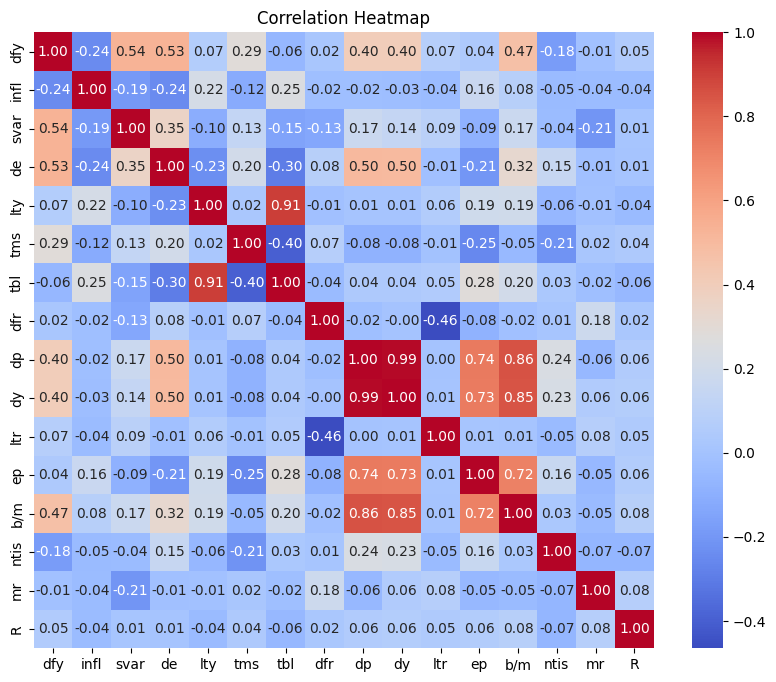

In [652]:
correlation_matrix=df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix,annot=True,fmt=".2f",cmap="coolwarm")
plt.title('Correlation Heatmap')

#### Correlation analysis with R

Text(0.5, 1.0, 'Correlation Heatmap with R')

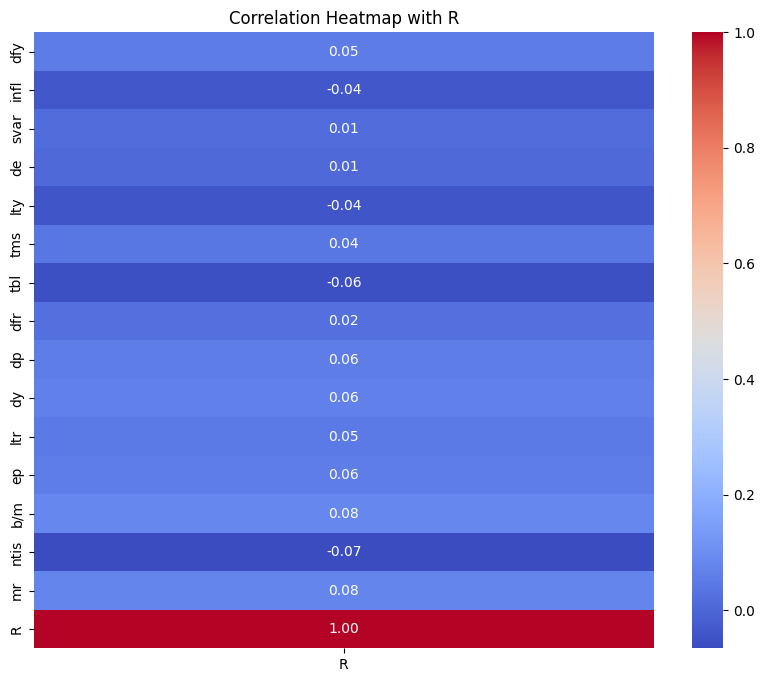

In [653]:
target_correlation = correlation_matrix[['R']]
plt.figure(figsize=(10,8))
sns.heatmap(target_correlation,annot=True,fmt=".2f",cmap="coolwarm")
plt.title('Correlation Heatmap with R')

### Residual plot


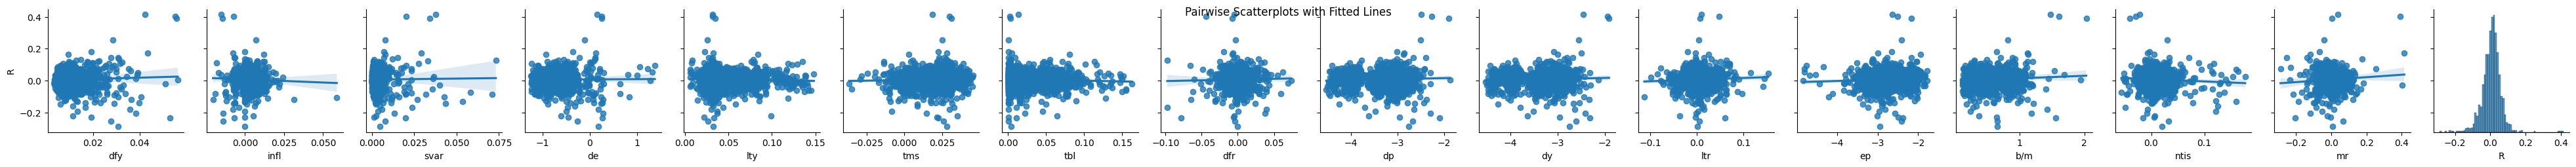

In [654]:
sns.pairplot(df,y_vars=['R'],x_vars=df.select_dtypes(include='number').columns,kind='reg')
plt.suptitle("Pairwise Scatterplots with Fitted Lines")
plt.show()

### Box Plot
This is the analysis of the skewness of the data

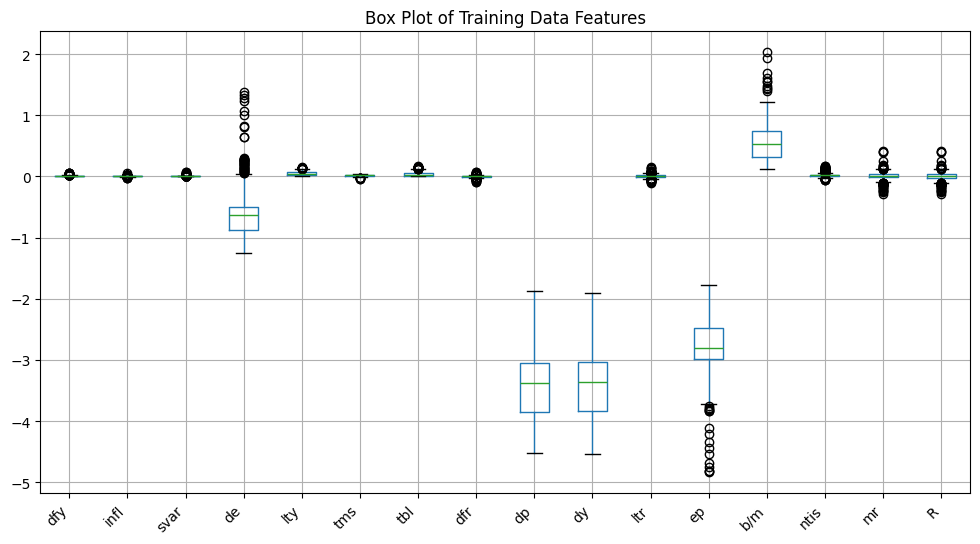

In [655]:
plt.figure(figsize=(12, 6))
df.boxplot()
plt.title('Box Plot of Training Data Features')
plt.xticks(rotation=45, ha='right')
plt.show()

### Autocorrelation and Partial Autocorrelation Analysis

#### 12 Month lag

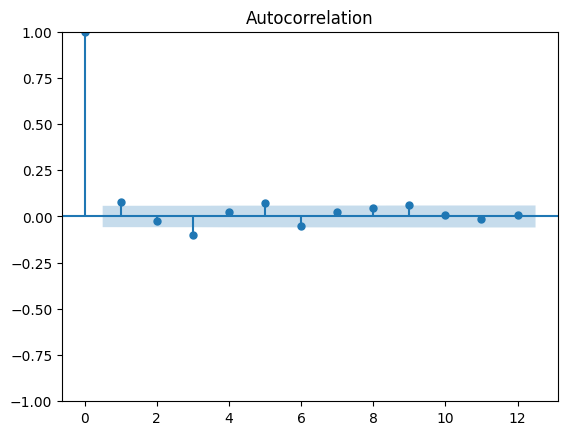

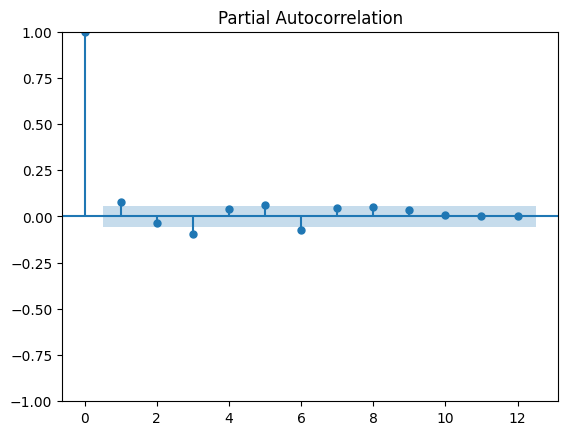

In [656]:
plot_acf(df['mr'],lags=12)
plot_pacf(df['mr'],lags=12)
plt.show()

#### 24 Month lag

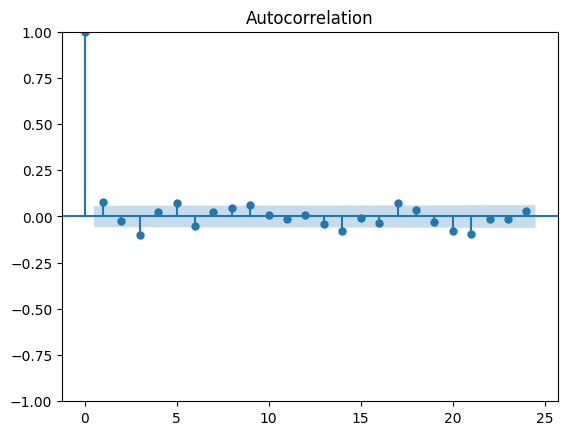

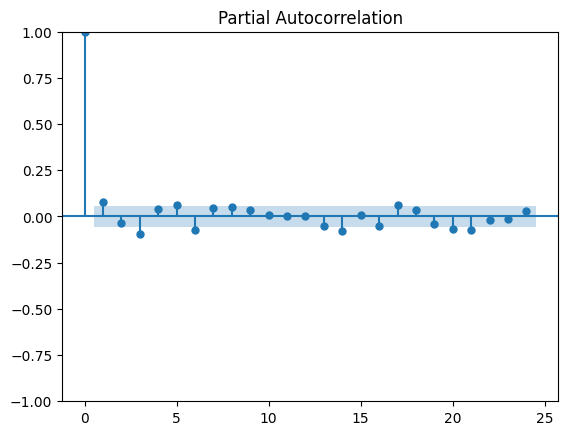

In [657]:
plot_acf(df['mr'],lags=24)
plot_pacf(df['mr'],lags=24)
plt.show()

# Pre-processing

## Feature Engineering

### Create a new feature for B/M and DP

In [658]:
df['dp_dy_product'] = (df['dp'] * df['dy'])
df['dp_dy_average'] = (df['dp'] + df['dy']) / 2
# df = df.drop('dp', axis=1)
df = df.drop('dy', axis=1)

#### Analyse New Features 

### Moving Averages and Rolling Volitility 

#### Moving average for default yield spread

In [659]:
df['dfy_ma3'] = df['dfy'].rolling(window=3).mean()
df = df.drop('dfy', axis=1)



#### Moving average and rolling volatility for stock variance

In [660]:
df['svar_ma3'] = df['svar'].rolling(window=3).mean()
df['svar_vol3'] = df['svar'].rolling(window=3).std()
# df = df.drop('svar', axis=1)

#### Re-analyse data moving average and roling volitility 

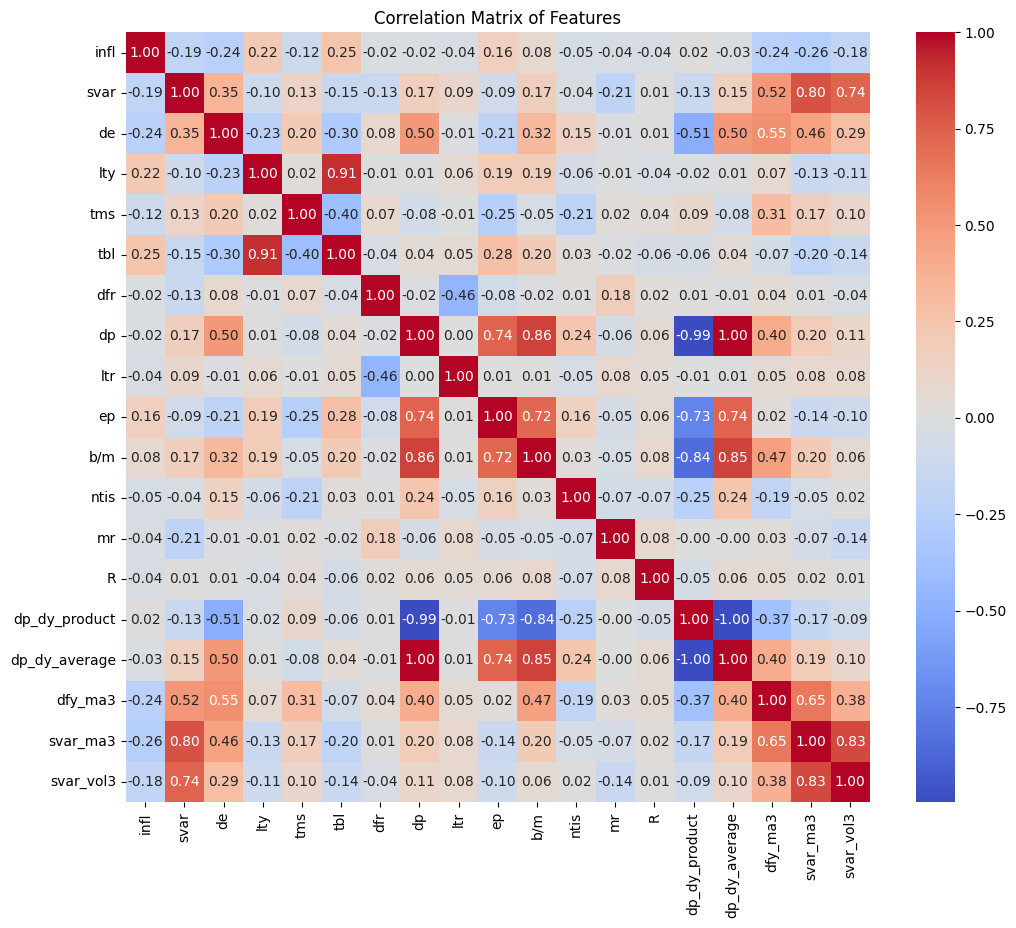

In [661]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

### Lagging 

#### Lag Market Returns 

In [662]:

lags_mr = list(range(1, 13,2)) + list(range(24, 60, 12))
# Apply lags for 'mr'
for lag in lags_mr:
    df[f'mr_lag{lag}'] = df['mr'].shift(lag)

# Handle missing values
df = df.fillna(method='ffill').fillna(method='bfill')

assert not df.isnull().values.any(), "NaN values still exist!"

/var/folders/vw/trk5pzwn1qg69p8f6mv4gpf00000gn/T/ipykernel_11570/934551410.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


#### Lag Fundamental fators 

In [663]:
lags_tms_dfy = list(range(1, 6, 2) ) # Monthly lags up to 12 months
for lag in lags_tms_dfy:
    df[f'tms_lag{lag}'] = df['tms'].shift(lag)
    df[f'ntis_lag{lag}'] = df['ntis'].shift(lag)
    df[f'dfy_ma3_lag{lag}'] = df['dfy_ma3'].shift(lag)

# Handle missing values
df = df.fillna(method='ffill').fillna(method='bfill')
assert not df.isnull().values.any(), "NaN values still exist!"

/var/folders/vw/trk5pzwn1qg69p8f6mv4gpf00000gn/T/ipykernel_11570/1468953958.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


#### Lag Economic Factors

In [664]:
lags_infl_ltr_bm = list(range(1, 6,2))  # Monthly lags for slower-moving variables
# Apply lags for 'infl', 'ltr', and 'b/m'
for lag in lags_infl_ltr_bm:
    df[f'infl_lag{lag}'] = df['infl'].shift(lag)
    df[f'ltr_lag{lag}'] = df['ltr'].shift(lag)
df[f'b/m{1}'] = df['b/m'].shift(1)
# Handle missing values
df = df.fillna(method='ffill').fillna(method='bfill')
assert not df.isnull().values.any(), "NaN values still exist!"

 

/var/folders/vw/trk5pzwn1qg69p8f6mv4gpf00000gn/T/ipykernel_11570/916812467.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


#### Analyse

### Dropping columns

#### Drop Book to market ratio

In [665]:
df = df.drop('b/m', axis=1)

#### Drop long term yield 
Dropping LTY and TBL because the relationship is covered in term spread 

In [666]:
df = df.drop('lty', axis=1)

#### Analyse 

## Data Spliting

In [667]:
split_date='2019-01-01'
train_data=df[df.index <split_date]
x_train=train_data.drop('R',axis=1)
y_train=train_data[['R']]
test_data=df[df.index >=split_date]
x_test=test_data.drop('R',axis=1)
y_test=test_data[['R']]
x_train.shape

(1104, 41)

### Review Split 

## Data Transformation
The evaluation of the data revealed a high standard deviation in certain features. To mitigate the potential impact of this variability and ensure features contribute equally to model training, data standardization was applied. This process transforms the data to have zero mean and unit variance, effectively balancing the dataset.

### Data Scaling

In [668]:
scaler_x = StandardScaler()
columns = x_train.columns

x_train[columns] = scaler_x.fit_transform(x_train[columns])  # Fit on x_train, transform x_train
x_test[columns] = scaler_x.transform(x_test[columns])        # Transform x_test using the same scaler

### Analyse Transformation

In [669]:
x_train.describe()

,infl,svar,de,tms,tbl,dfr,dp,ltr,ep,ntis,...,tms_lag5,ntis_lag5,dfy_ma3_lag5,infl_lag1,ltr_lag1,infl_lag3,ltr_lag3,infl_lag5,ltr_lag5,b/m1
count,1104.000000,1.104000e+03,1.104000e+03,1.104000e+03,1.104000e+03,1104.000000,1.104000e+03,1.104000e+03,1.104000e+03,1104.000000,...,1.104000e+03,1.104000e+03,1.104000e+03,1.104000e+03,1.104000e+03,1.104000e+03,1.104000e+03,1104.000000,1104.000000,1.104000e+03
mean,0.000000,-7.723291e-17,-1.029772e-16,2.574430e-16,-1.029772e-16,0.000000,-6.178632e-16,-1.287215e-17,-6.178632e-16,0.000000,...,2.059544e-16,5.148860e-17,1.609019e-16,-1.287215e-17,1.930823e-17,-1.287215e-17,-1.287215e-17,0.000000,0.000000,-2.059544e-16
std,1.000453,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453,1.000453e+00,1.000453e+00,1.000453e+00,1.000453,...,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453,1.000453,1.000453e+00
min,-4.334089,-4.854632e-01,-1.849301e+00,-4.130574e+00,-1.095474e+00,-7.154197,-2.471702e+00,-4.795727e+00,-5.033374e+00,-2.824147,...,-4.122536e+00,-2.839755e+00,-1.159668e+00,-4.334052e+00,-4.801779e+00,-4.334593e+00,-4.819021e+00,-4.335236,-4.821035,-1.685676e+00
25%,-0.458492,-3.775397e-01,-6.712214e-01,-6.411073e-01,-9.528309e-01,-0.397168,-5.694032e-01,-4.785229e-01,-5.034165e-01,-0.436538,...,-6.458269e-01,-4.439770e-01,-6.264143e-01,-4.590860e-01,-4.776984e-01,-4.606161e-01,-4.792745e-01,-0.462165,-0.478899,-8.602058e-01
50%,-0.002723,-2.790525e-01,2.515773e-02,3.675819e-02,-1.456002e-01,0.012348,6.122648e-02,-6.482500e-02,-1.235244e-01,0.000969,...,3.874622e-02,-9.270953e-03,-3.182035e-01,-2.839715e-03,-6.334148e-02,-2.949829e-03,-6.362571e-02,-0.001732,-0.063206,-1.007907e-01
75%,0.494096,-7.143651e-02,4.253461e-01,6.915147e-01,5.684261e-01,0.392614,7.486202e-01,4.604895e-01,6.507735e-01,0.406949,...,6.925521e-01,3.999060e-01,2.896566e-01,4.945554e-01,4.587071e-01,5.006097e-01,4.567695e-01,0.502964,0.456409,6.818500e-01
max,10.636355,1.190379e+01,6.149646e+00,2.185900e+00,4.185565e+00,5.365319,3.251306e+00,6.046436e+00,2.321679e+00,6.213600,...,2.184768e+00,6.207468e+00,6.550494e+00,1.063395e+01,6.057653e+00,1.062959e+01,6.072005e+00,10.625450,6.073405,5.523868e+00


# Models

## Linear Regression

### OLS

#### Training

In [670]:
ols = LinearRegression()
ols = ols.fit(x_train, y_train)
y_insample_pred_ols = ols.predict(x_train)
y_outsample_pred_ols = ols.predict(x_test)

#### Analysing OLS Coeeficient 

In [671]:
# Assuming 'ols' is the fitted Linear Regression model from your code
# Access coefficients
coefficients = ols.coef_

# Access feature names
feature_names = x_train.columns

# Create a DataFrame for coefficients and their importance
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients[0]})

# Sort by absolute value of coefficients (importance)
coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)
coefficients_df = coefficients_df.drop(columns=['Abs_Coefficient'])

# Display the coefficients and their importance
coefficients_df

,Feature,Coefficient
12,dp_dy_average,-0.863363
6,dp,0.495315
8,ep,0.341364
2,de,0.266132
30,dfy_ma3_lag3,-0.059793
10,mr,0.051703
27,dfy_ma3_lag1,0.048870
32,ntis_lag5,-0.023682
33,dfy_ma3_lag5,0.020675
26,ntis_lag1,0.016550


### Ridge

#### Time serires Cross validation

In [672]:
tscv = TimeSeriesSplit(n_splits=4, test_size=12 )

####  Alpha Cross Validation

In [673]:
alphas = np.logspace(-4, 4, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=tscv, scoring='neg_mean_squared_error')
ridge_cv.fit(x_train, y_train)

RidgeCV(alphas=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-0...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
        cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=12),
        scoring='neg_mean_squared_error')

#### Training

In [674]:
ridge = Ridge(alpha=ridge_cv.alpha_,max_iter=1000,fit_intercept=False)
ridge.fit(x_train, y_train)
y_insample_pred_ridge = ridge.predict(x_train)
y_outsample_pred_ridge = ridge.predict(x_test)

### Lasso

#### Time serires Cross validation

In [675]:
tscv = TimeSeriesSplit(n_splits=4, test_size=12 )

#### Alpha Cross Validation

In [676]:
alphas = np.logspace(-4, 4, 100) 
lasso_cv = LassoCV(alphas=alphas, cv=tscv)
lasso_cv.fit(x_train, y_train)

/opt/anaconda3/envs/Qmul/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1659: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-0...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
        cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=12))

#### Analysing the coefficent

In [677]:
# @ Analysing the coefficent
coefficients = lasso_cv.coef_

feature_names = x_train.columns
dropped_features = feature_names[np.where(coefficients ==0)]
print(dropped_features)
import numpy as np

importance = np.abs(coefficients)
sorted_indices = np.argsort(importance)[::-1]  # Indices sorted by importance

# If you have feature names (e.g., from a pandas DataFrame):
for i in sorted_indices:
    print(f"{feature_names[i]}: {importance[i]}")

Index(['dp', 'ep', 'dp_dy_average', 'dfy_ma3', 'mr_lag48', 'tms_lag1',
       'tms_lag5'],
      dtype='object')
dfy_ma3_lag3: 0.043024741013562705
dfy_ma3_lag1: 0.027749809611472373
ntis_lag5: 0.020236340442165112
ntis_lag3: 0.014104244917948256
dfy_ma3_lag5: 0.01195563158869718
b/m1: 0.010678373049793317
ntis_lag1: 0.004605022717273926
ltr: 0.004484789481918566
mr_lag5: 0.004328893024494153
mr_lag3: 0.004306033073114732
dfr: 0.00404479444357531
tbl: 0.003740537948603583
infl_lag5: 0.0035302462858463287
infl_lag3: 0.0034535497588880915
de: 0.003267038807375378
ltr_lag5: 0.0031391624317790375
mr_lag24: 0.0023704771815459716
ntis: 0.00234493330409107
mr_lag7: 0.0018786006381589656
mr_lag36: 0.001739943929282562
svar_vol3: 0.0017390361071043439
mr: 0.0017019584996789952
tms: 0.001132996932970958
dp_dy_product: 0.0009705939961225477
mr_lag1: 0.0009625613778350123
infl: 0.0009330799966302165
ltr_lag3: 0.0008613621862577907
mr_lag9: 0.0008520414121299076
svar: 0.0006480887166274848
svar_ma3

#### Training

In [678]:
lasso = Lasso(alpha=lasso_cv.alpha_,max_iter=1000,fit_intercept=False)
lasso.fit(x_train, y_train)
y_insample_pred_lasso = lasso.predict(x_train)
y_outsample_pred_lasso = lasso.predict(x_test)

## Random Forest

In [679]:

# Implement Random Forest with optimized hyperparameter tuning
rf = RandomForestRegressor(random_state=42, n_jobs=- 4)  # Use all CPU cores

rf_params = {
    "n_estimators": [50, 100, 200, 300],  # Fewer estimators for faster training
    "max_depth": [None, 10, 20, 30],     # Balanced depth options
    "min_samples_split": [2, 5, 10, 15], # Tuning sample split criteria
}

# Use fewer CV folds if speed is critical
rf_random = RandomizedSearchCV(
    rf, rf_params, cv=TimeSeriesSplit(n_splits=4, test_size=12), scoring="neg_mean_squared_error"
)


# Ensure y_train is a 1D array
y_train_1d = y_train.to_numpy().ravel()

# Fit the model
rf_random.fit(x_train, y_train_1d)

print("Best Random Forest Params:", rf_random.best_params_)

# Predict and evaluate Random Forest
y_train_pred_rf = rf_random.best_estimator_.predict(x_train)
y_test_pred_rf = rf_random.best_estimator_.predict(x_test)

Best Random Forest Params: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': None}


# Performance Test

## Performance Metrics

### Linear Regression 

#### In-sample Performance Comparism

In [680]:
mse_insample_ols = mean_squared_error(y_train, y_insample_pred_ols)
r2_insample_ols = r2_score(y_train, y_insample_pred_ols)
mse_insample_ridge = mean_squared_error(y_train, y_insample_pred_ridge)
r2_insample_ridge = r2_score(y_train, y_insample_pred_ridge)
mse_insample_lasso = mean_squared_error(y_train, y_insample_pred_lasso)
r2_insample_lasso = r2_score(y_train, y_insample_pred_lasso)
print('Model Insample Performance Comparison:')
print(f'OLS MSE: {mse_insample_ols:.4f}, R-squared: {r2_insample_ols:.4f}')
print(f'Ridge MSE: {mse_insample_ridge:.4f}, R-squared: {r2_insample_ridge:.4f}')
print(f'Lasso MSE: {mse_insample_lasso:.4f}, R-squared: {r2_insample_lasso:.4f}')


Model Insample Performance Comparison:
OLS MSE: 0.0027, R-squared: 0.0974
Ridge MSE: 0.0027, R-squared: 0.0770
Lasso MSE: 0.0027, R-squared: 0.0735


#### out-sample Performance Comparism

In [681]:
mse_outsample_ols = mean_squared_error(y_test, y_outsample_pred_ols)
r2_outsample_ols = r2_score(y_test, y_outsample_pred_ols)
mse_outsample_ridge = mean_squared_error(y_test, y_outsample_pred_ridge)
r2_outsample_ridge = r2_score(y_test, y_outsample_pred_ridge)
mse_outsample_lasso = mean_squared_error(y_test, y_outsample_pred_lasso)
r2_outsample_lasso = r2_score(y_test, y_outsample_pred_lasso)
print('Model Outsample Performance Comparison:')
print(f'OLS MSE: {mse_outsample_ols:.4f}, R-squared: {r2_outsample_ols:.4f}')
print(f'Ridge MSE: {mse_outsample_ridge:.4f}, R-squared: {r2_outsample_ridge:.4f}')
print(f'Lasso MSE: {mse_outsample_lasso:.4f}, R-squared: {r2_outsample_lasso:.4f}')

Model Outsample Performance Comparison:
OLS MSE: 0.0035, R-squared: -0.1412
Ridge MSE: 0.0036, R-squared: -0.1586
Lasso MSE: 0.0036, R-squared: -0.1478


### Random Forest

#### insample Performance comparism 

In [682]:
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
print(f"Random Forest - Training MSE: {mse_train_rf:.4f}, Training R²: {r2_train_rf:.4f}")

Random Forest - Training MSE: 0.0005, Training R²: 0.8227


#### out-sample Performance comparism

In [683]:
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)
print(f"Random Forest - Testing MSE: {mse_test_rf:.4f}, Testing R²: {r2_test_rf:.4f}")

Random Forest - Testing MSE: 0.0038, Testing R²: -0.2427


## Visuals

### Plot for Linear Regression   


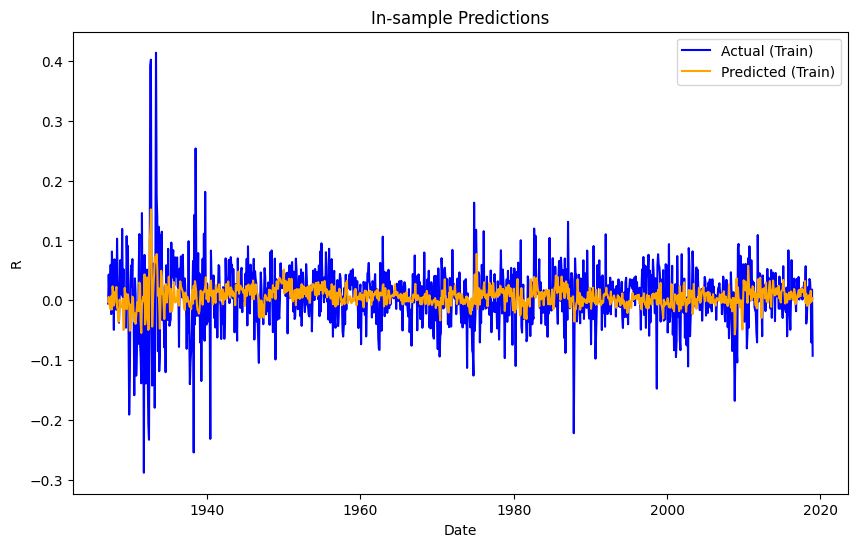

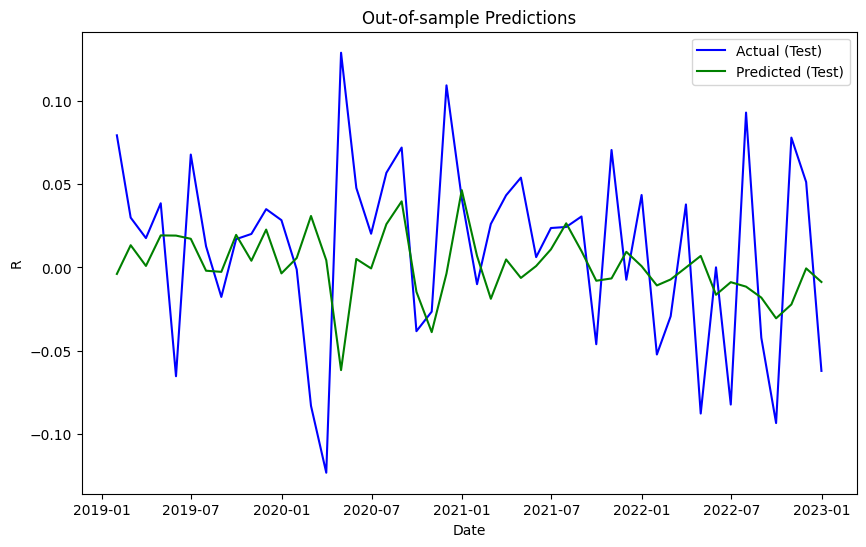

In [684]:
# In-sample Predictions
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label="Actual (Train)", color="blue")
plt.plot(y_train.index, y_insample_pred_ols, label="Predicted (Train)", color="orange")
plt.title("In-sample Predictions")
plt.xlabel("Date")
plt.ylabel("R")
plt.legend()
plt.show()

# Out-of-sample Predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual (Test)", color="blue")
plt.plot(y_test.index, y_outsample_pred_ols, label="Predicted (Test)", color="green")
plt.title("Out-of-sample Predictions")
plt.xlabel("Date")
plt.ylabel("R")
plt.legend()
plt.show()


### Plot for Random Forest


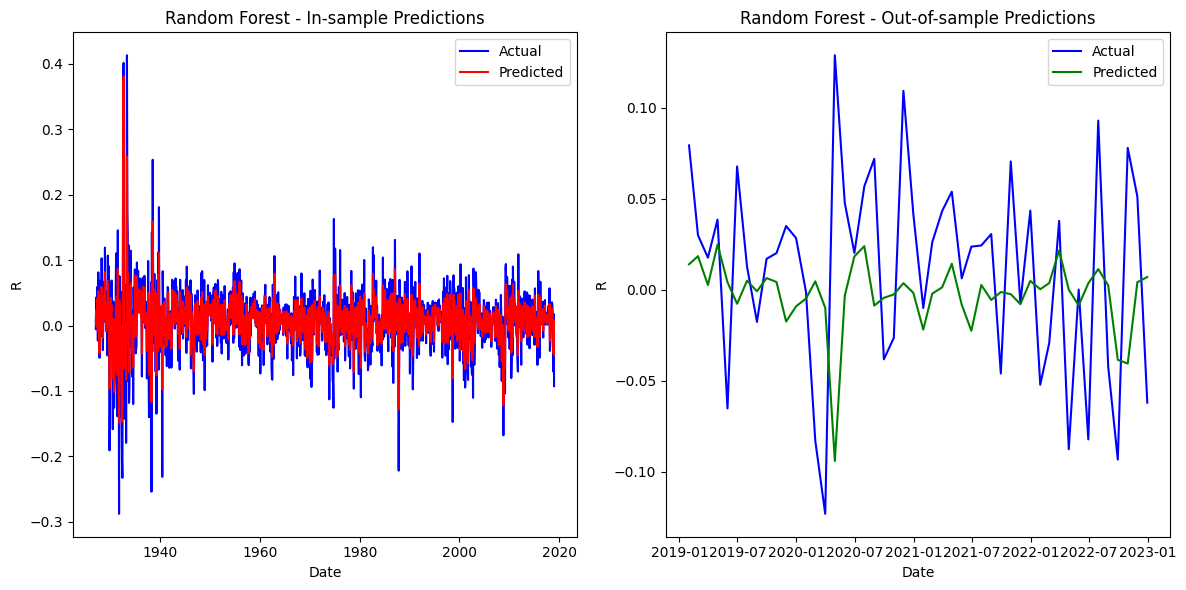

In [685]:
plt.figure(figsize=(12, 6))

# In-sample plot
plt.subplot(1, 2, 1)
plt.plot(y_train.index, y_train, label='Actual', color='blue')
plt.plot(y_train.index, y_train_pred_rf, label='Predicted', color='red')
plt.title('Random Forest - In-sample Predictions')
plt.xlabel('Date')
plt.ylabel('R')
plt.legend()

# Out-of-sample plot
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_test_pred_rf, label='Predicted', color='green')
plt.title('Random Forest - Out-of-sample Predictions')
plt.xlabel('Date')
plt.ylabel('R')
plt.legend()

plt.tight_layout()
plt.show()

# Financial Analysis

## Analysing data of Know Historical events

## Market Valuation Signal

### Dividend to Price Ratio vs. Book to Market Ratio
The Graph shows strong correlation between the book to market ratio and Divends to price ratio

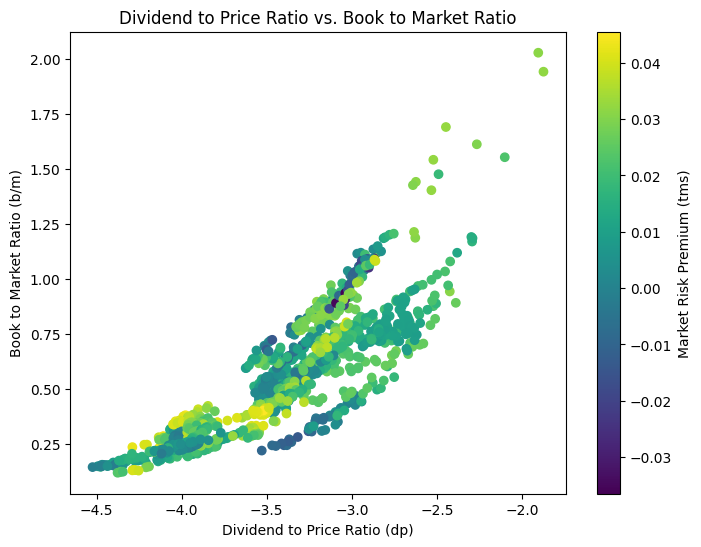

In [686]:
plt.figure(figsize=(8, 6))
plt.scatter(DF_FINAL['dp'], DF_FINAL['b/m'], c=DF_FINAL['tms'], cmap='viridis')
plt.xlabel('Dividend to Price Ratio (dp)')
plt.ylabel('Book to Market Ratio (b/m)')
plt.title('Dividend to Price Ratio vs. Book to Market Ratio')
_ = plt.colorbar(label='Market Risk Premium (tms)')

### Dividend price vs Dividend Yield
Dividend price vs Dividend Yield

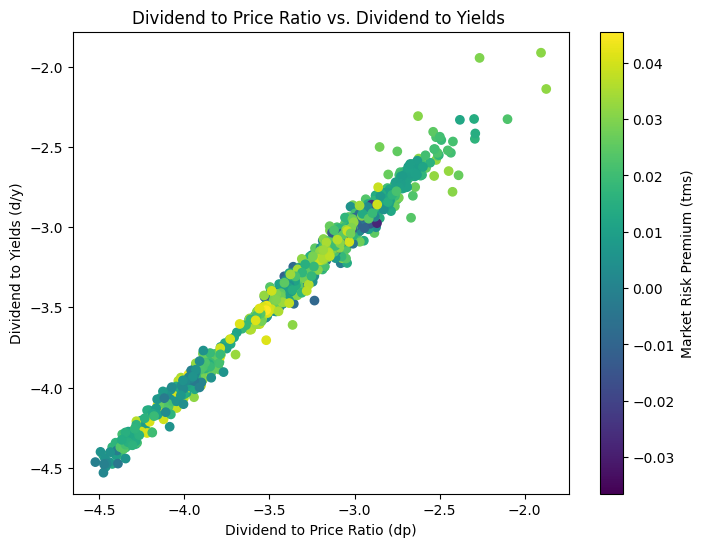

In [687]:
plt.figure(figsize=(8, 6))
plt.scatter(DF_FINAL['dp'], DF_FINAL['dy'], c=df['tms'], cmap='viridis')
plt.xlabel('Dividend to Price Ratio (dp)')
plt.ylabel('Dividend to Yields (d/y)')
plt.title('Dividend to Price Ratio vs. Dividend to Yields ')
_ = plt.colorbar(label='Market Risk Premium (tms)')

##  Spike Analysis 

[(Timestamp('1930-06-30 00:00:00'), Timestamp('1930-06-30 00:00:00')), (Timestamp('1930-07-31 00:00:00'), Timestamp('1930-07-31 00:00:00')), (Timestamp('1931-06-30 00:00:00'), Timestamp('1931-06-30 00:00:00')), (Timestamp('1931-09-30 00:00:00'), Timestamp('1931-09-30 00:00:00')), (Timestamp('1931-10-31 00:00:00'), Timestamp('1931-11-30 00:00:00')), (Timestamp('1931-12-31 00:00:00'), Timestamp('1932-02-29 00:00:00')), (Timestamp('1932-03-31 00:00:00'), Timestamp('1932-04-30 00:00:00')), (Timestamp('1932-05-31 00:00:00'), Timestamp('1932-06-30 00:00:00')), (Timestamp('1932-07-31 00:00:00'), Timestamp('1932-09-30 00:00:00')), (Timestamp('1932-10-31 00:00:00'), Timestamp('1932-11-30 00:00:00')), (Timestamp('1932-12-31 00:00:00'), Timestamp('1933-02-28 00:00:00')), (Timestamp('1933-03-31 00:00:00'), Timestamp('1933-04-30 00:00:00')), (Timestamp('1933-05-31 00:00:00'), Timestamp('1933-06-30 00:00:00')), (Timestamp('1933-07-31 00:00:00'), Timestamp('1933-09-30 00:00:00')), (Timestamp('1933-10

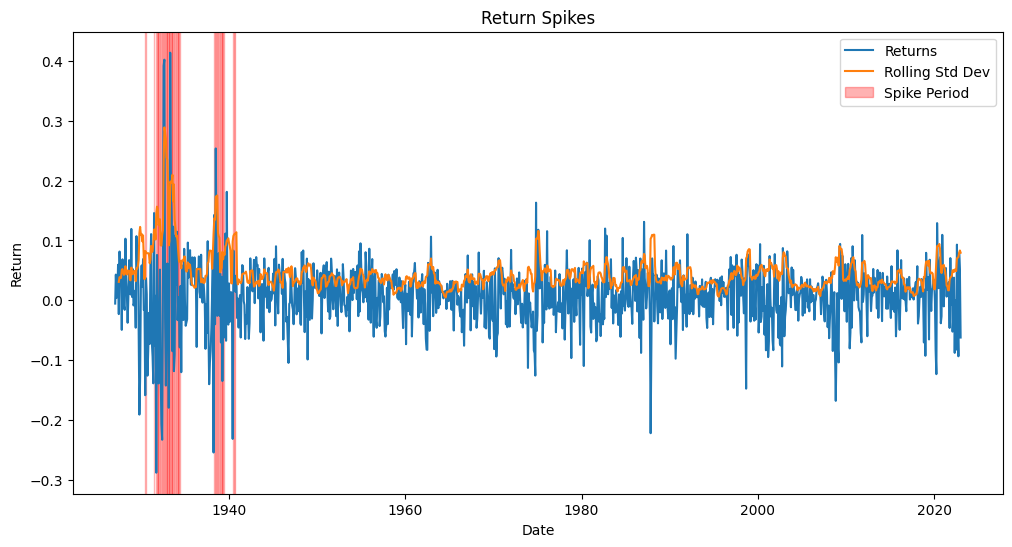

In [688]:
# Assuming 'R' column represents returns and the index is a datetime index.
def find_spike_periods(df, return_column='R', threshold=2):
    """
    Finds periods of spikes in returns exceeding a given threshold.

    Args:
        DF_FINAL: DataFrame with a datetime index and a return column.
        return_column: The name of the column containing returns.
        threshold: The standard deviation threshold to identify a spike.

    Returns:
        A list of tuples, where each tuple represents a spike period
        (start_date, end_date).
    """

    # Calculate rolling standard deviation to identify volatility
    rolling_std = DF_FINAL[return_column].rolling(window=12).std() # Adjust window size as needed

    # Identify spikes based on threshold
    spikes = DF_FINAL[return_column][rolling_std > threshold * rolling_std.mean()]

    # Group consecutive spikes into periods
    spike_periods = []
    start_date = None
    for date in spikes.index:
        if start_date is None:
            start_date = date
        elif date != spikes.index[spikes.index.get_loc(date) - 1] + pd.DateOffset(months=1): # Adjust for your data freq
            spike_periods.append((start_date, spikes.index[spikes.index.get_loc(date) - 1]))
            start_date = date
    if start_date is not None:
        spike_periods.append((start_date, spikes.index[-1]))

    return spike_periods

# Example usage:
spike_periods = find_spike_periods(DF_FINAL)
print(spike_periods)

# For visualization
plt.figure(figsize=(12, 6))
plt.plot(DF_FINAL['R'], label='Returns')
plt.plot(DF_FINAL['R'].rolling(window=6).std(), label='Rolling Std Dev')

for start, end in spike_periods:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Spike Period' if start==spike_periods[0][0] else '') # Plot each spike as a shaded area
plt.legend()
plt.title('Return Spikes')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()